# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ast



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img




from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed

from sklearn.metrics import classification_report, confusion_matrix


# Access Dataset
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem. 




In [2]:
df_data = pd.read_csv('dataset\\full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [32]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Let's assume 'df' is your DataFrame and you have a 'target' column with single-character labels

# Instantiate the label encoder
label_encoder = LabelEncoder()

# Fit label encoder and return encoded integer labels
integer_encoded = label_encoder.fit_transform(df_data['target'])

# Convert integer_encoded to one-hot encoding
one_hot_encoded = to_categorical(integer_encoded)

# Now, 'one_hot_encoded' contains your target variable for the multi-class classification

print(one_hot_encoded)


[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


# Evaluating the first round of training of the ResNet 50 Model 
- To overcome the challenges faced in the first train of the model, such as overfitting and class imbalance, hence we will apply data augmentation, model regularisation and early stopping. 


# Data Distribution
- Below is shown the distribution of images available for each different ocular condition. The different diseases are encoded into individual coloums as N (Normal), D (Diabetes), G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia), O (Other diseases/abnormalities). They have binary indicators 0 or 1 to specify the absence or presence of a condition. This is also know as one-hot encoding. Thus, the dataset structure indicates multiple labels per image, allowing for multi-label classifcation.

- Conditions G, C, A, H and M are minority classes since they have low image samples, causing class imbalance. 

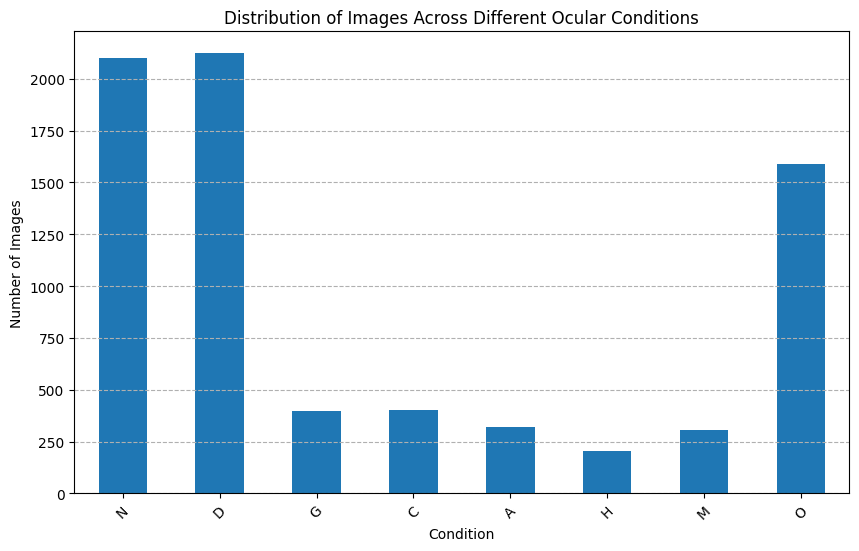

In [3]:
# Sum up the occurrences of each condition
class_counts = df_data[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].sum()

# Plotting
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Images Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

In [5]:
class_distribution = df_data[['N','D','G', 'C', 'A', 'H', 'M', 'O']].sum()
print(class_distribution)

N    2101
D    2123
G     397
C     402
A     319
H     203
M     306
O    1588
dtype: int64


# Dealing with class imbalance - Data Augmentation 
- Data augmentation involves artificially increasing the size of your dataset by generating new data by resusing exisitng data, useful for underrepresented classes. Examples include rotations, flipping, noise, colour variations. 
- Will increase each minority class size to 2000 images by using the class counts and classes with less than 2000 images will be augmeneted to increase their size to 2000.
- The following minority classes should have their class sizes balanced -  G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia).

In [33]:
# Split the DataFrame into training and test sets
df_train, df_test = train_test_split(df_data, test_size=0.2, random_state=42)

In [34]:
df_train.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
2273,3159,62,Male,3159_left.jpg,3159_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3159_right.jpg
5609,3315,57,Male,3315_left.jpg,3315_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3315_left.jpg
4614,2152,58,Female,2152_left.jpg,2152_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",2152_left.jpg
3658,542,64,Male,542_left.jpg,542_right.jpg,diabetic retinopathy,maculopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",542_left.jpg
471,540,82,Male,540_left.jpg,540_right.jpg,normal fundus,dry age-related macular degeneration，diabetic ...,0,1,0,0,1,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",540_right.jpg


# Data Distribution Before Augmentation 

labels
['N']    2304
['D']    1275
['O']     572
['C']     235
['G']     223
['A']     220
['M']     184
['H']     100
Name: count, dtype: int64


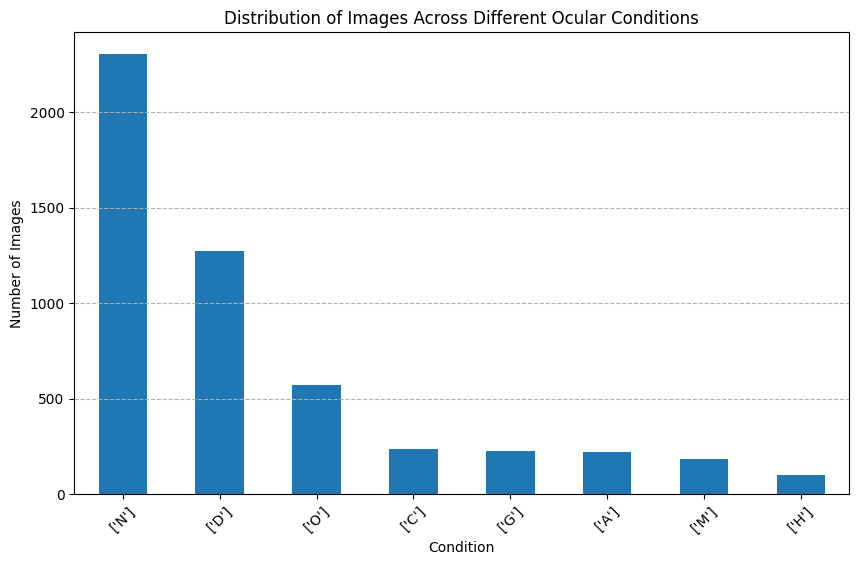

In [48]:
class_counts = df_train['labels'].value_counts()
print(class_counts)

# Plotting
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Images Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

# Augmentation 

In [57]:
import math

def calculate_augmentations_needed(current_distribution, target_count):
    # Calculate the augmentations needed for each class to reach the target count
    augmentations_needed_per_class = {
        class_label: target_count - count 
        for class_label, count in current_distribution.items() if count < target_count
    }
    
    # Calculate the total augmentations needed
    total_augmentations_needed = sum(augmentations_needed_per_class.values())
    
    # Calculate the average number of augmentations needed per image in each under-represented class
    augmentations_needed_per_image = {
        class_label: math.ceil(augmentations_needed / current_distribution[class_label])
        for class_label, augmentations_needed in augmentations_needed_per_class.items()
    }
    
    return augmentations_needed_per_image, total_augmentations_needed

# Use the function
current_distribution = {
    'N': 2304,
    'D': 1275,
    'G': 223,
    'C': 235,
    'A': 220,
    'H': 100,
    'M': 184,
    'O': 572
}
target_count = max(current_distribution.values())  # The target is the class with the maximum instances
augmentations_per_image, total_needed = calculate_augmentations_needed(current_distribution, target_count)

print(f"Augmentations needed per image (rounded up): {augmentations_per_image}")
print(f"Total augmentations needed (sum of rounded values): {total_needed}")



Augmentations needed per image (rounded up): {'D': 1, 'G': 10, 'C': 9, 'A': 10, 'H': 23, 'M': 12, 'O': 4}
Total augmentations needed (sum of rounded values): 13319


In [58]:

# Initialize the ImageDataGenerator with suitable augmentations for fundus images
augmentation = ImageDataGenerator(
    rotation_range=5,         # Slightly reduce the rotation range
    zoom_range=0.02,          # Reduce the zoom range
    brightness_range=(0.95, 1.05), # Narrow the brightness range
    fill_mode='constant',     # Change fill mode to 'constant'
    cval=0,                   # Set constant value to 0 (black) which might be more appropriate for fundus
    )

save_directory = 'dataset/augmented_images/'
os.makedirs(save_directory, exist_ok=True)

# The augmentations_needed dictionary now uses numerical indices as keys
augmentations_needed = { 0:0, 1:0.5, 2:10, 3:9, 4:10, 5:23, 6:12, 7:3 }

def augment_and_save_image(row, save_directory, augmentation, augmentations_needed):
    img_path = os.path.join('dataset/ODIR-5K/Training Images', row['filename'])
    img = load_img(img_path)
    img = img.resize((256, 256))  # Resize image if necessary
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    augmented_rows = []

    # Determine the number of augmentations needed based on the target
    # Determine the number of augmentations needed based on the target
    targets = eval(row['target']) if isinstance(row['target'], str) else row['target']
    max_augmentations_needed = max([augmentations_needed[i] for i, label in enumerate(targets) if label == 1])

    for i in range(max_augmentations_needed):
        for batch in augmentation.flow(x, batch_size=1, save_prefix='aug_', save_format='jpeg'):
            # Create a unique filename using class index and augmentation index
            unique_filename = f'aug_{i}_{row["filename"]}'
            # Generate the full path for saving
            augmented_image_path = os.path.join(save_directory, unique_filename)
            # Save the image to the full path
            save_img(augmented_image_path, batch[0])

            # Replicate the row and update the filename
            augmented_row = row.copy()
            augmented_row['filename'] = unique_filename
            augmented_rows.append(augmented_row)

            break  # Only save one image per augmentation to avoid infinite loop

    return augmented_rows  # Return the augmented rows with updated filenames

# Usage with ThreadPoolExecutor
augmented_data = []

with ThreadPoolExecutor(max_workers=4) as executor:
    tasks = []
    for _, row in df_train.iterrows():
        tasks.append(executor.submit(augment_and_save_image, row, save_directory, augmentation, augmentations_needed))

    for future in tqdm(as_completed(tasks), total=len(tasks), desc="Augmenting Images"):
        try:
            augmented_rows = future.result()
            augmented_data.extend(augmented_rows)  # Extend the list with augmented rows
        except Exception as e:
            print(f"Error processing image: {e}")

# Create a DataFrame from the augmented data
df_augmented = pd.DataFrame(augmented_data)

# Concatenate the original DataFrame with the new augmented DataFrame
df_combined = pd.concat([df_train, df_augmented], ignore_index=True)


Augmenting Images:   0%|          | 0/5113 [00:00<?, ?it/s]

Error processing image: 'float' object cannot be interpreted as an integer
Error processing image: 'float' object cannot be interpreted as an integer
Error processing image: 'float' object cannot be interpreted as an integer
Error processing image: 'float' object cannot be interpreted as an integer
Error processing image: 'float' object cannot be interpreted as an integer
Error processing image: 'float' object cannot be interpreted as an integer
Error processing image: 'float' object cannot be interpreted as an integer
Error processing image: 'float' object cannot be interpreted as an integer
Error processing image: 'float' object cannot be interpreted as an integer
Error processing image: 'float' object cannot be interpreted as an integer
Error processing image: 'float' object cannot be interpreted as an integer
Error processing image: 'float' object cannot be interpreted as an integer
Error processing image: 'float' object cannot be interpreted as an integer
Error processing image: '

In [51]:
df_augmented.head()

# save to csv

df_augmented.to_csv('dataset\\df_augmentedv2.csv', index=False)

In [52]:
df_combined.head()

# save to csv

df_combined.to_csv('dataset\\full_df_augmentedv2.csv', index=False)

# Data Distribution after Augmentation 

N       0
D    2890
G    2593
C    2285
A    2312
H    2459
M    2372
O    3340
dtype: int64


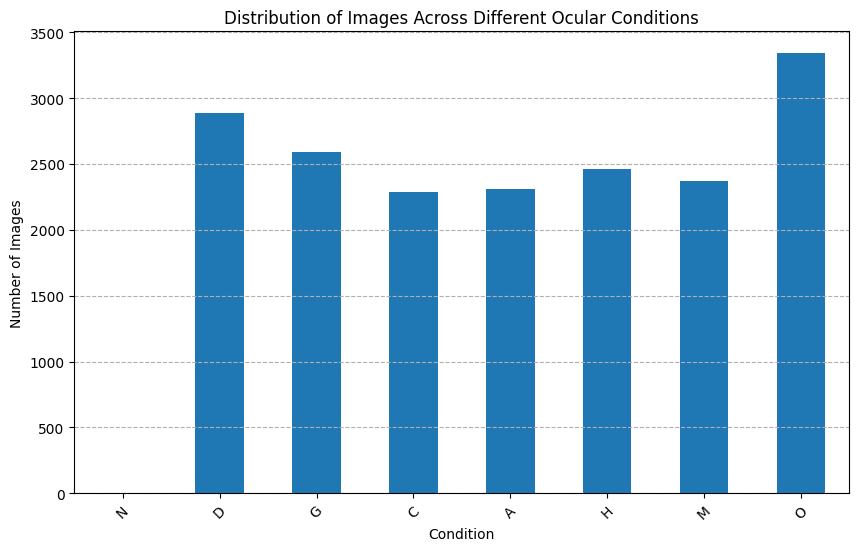

In [53]:
class_counts = df_augmented[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].sum()
print(class_counts)

# Plotting
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Images Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

Class N: 2304
Class D: 2550
Class G: 2453
Class C: 2350
Class A: 2420
Class H: 2400
Class M: 2392
Class O: 2288


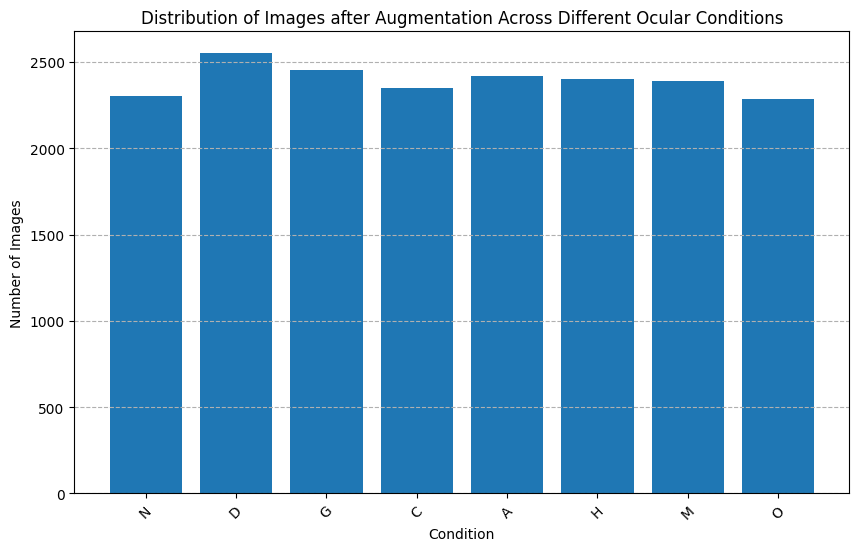

In [54]:

# Convert string representation of list to actual list using ast.literal_eval
df_combined['target'] = df_combined['target'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Ensure all lists are of equal length (this step assumes all lists should be length 8)
# If some 'target' entries are not lists or are lists of different lengths, this will give an error
assert all(len(t) == 8 for t in df_combined['target']), "Not all target lists are of length 8."

# Sum up all the target lists
class_distribution = np.sum(df_combined['target'].tolist(), axis=0)

# Assuming class_labels are in the correct order
class_labels = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Map the distribution counts to the class labels
class_distribution_dict = dict(zip(class_labels, class_distribution))

# Print the class distribution
for label, count in class_distribution_dict.items():
    print(f"Class {label}: {count}")
    
# Plotting
plt.figure(figsize=(10, 6))
class_distribution_dict = dict(zip(class_labels, class_distribution))
plt.bar(class_distribution_dict.keys(), class_distribution_dict.values())
plt.title('Distribution of Images after Augmentation Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')



In [55]:
df_combined = pd.read_csv('dataset\\full_df_augmented.csv')
df_combined.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,3159,62,Male,3159_left.jpg,3159_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3159_right.jpg
1,3315,57,Male,3315_left.jpg,3315_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3315_left.jpg
2,2152,58,Female,2152_left.jpg,2152_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",2152_left.jpg
3,542,64,Male,542_left.jpg,542_right.jpg,diabetic retinopathy,maculopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",542_left.jpg
4,540,82,Male,540_left.jpg,540_right.jpg,normal fundus,dry age-related macular degeneration，diabetic ...,0,1,0,0,1,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",540_right.jpg


Class N: 569
Class D: 333
Class G: 61
Class C: 58
Class A: 46
Class H: 28
Class M: 48
Class O: 136


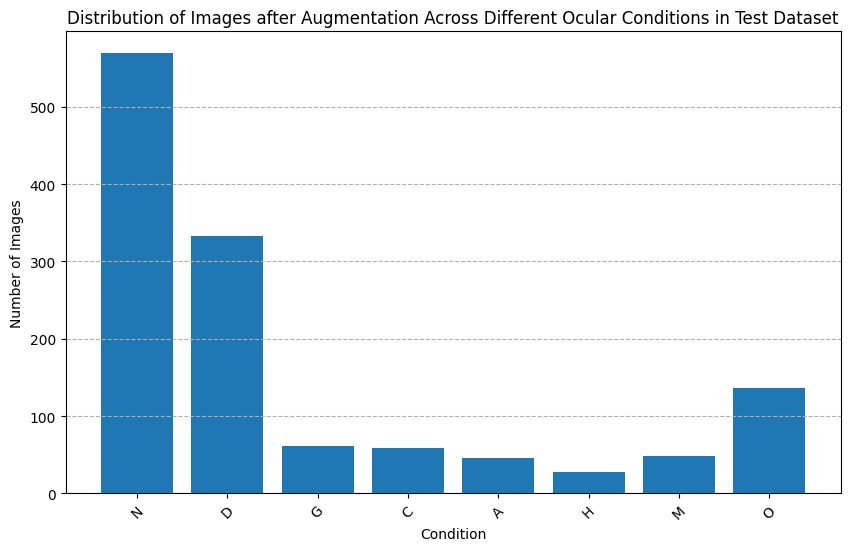

In [56]:

# Convert string representation of list to actual list using ast.literal_eval
df_test['target'] = df_test['target'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Ensure all lists are of equal length (this step assumes all lists should be length 8)
# If some 'target' entries are not lists or are lists of different lengths, this will give an error
assert all(len(t) == 8 for t in df_test['target']), "Not all target lists are of length 8."

# Sum up all the target lists
class_distribution = np.sum(df_test['target'].tolist(), axis=0)

# Assuming class_labels are in the correct order
class_labels = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Map the distribution counts to the class labels
class_distribution_dict = dict(zip(class_labels, class_distribution))

# Print the class distribution
for label, count in class_distribution_dict.items():
    print(f"Class {label}: {count}")
    
# Plotting
plt.figure(figsize=(10, 6))
class_distribution_dict = dict(zip(class_labels, class_distribution))
plt.bar(class_distribution_dict.keys(), class_distribution_dict.values())
plt.title('Distribution of Images after Augmentation Across Different Ocular Conditions in Test Dataset')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')



In [5]:
datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocess_input
    
)

train_generator = datagen.flow_from_dataframe(
    dataframe= df_combined,  # Use the training part of the split
    directory='dataset/augmented_train_img/', 
    x_col='filename',
    y_col='labels',
    subset='training',
    target_size=(256,256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df_combined,  # Use the training part of the split
    directory='dataset/augmented_train_img/',
    x_col='filename',
    y_col='labels',
    subset='validation',
    target_size=(256,256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 15784 validated image filenames belonging to 8 classes.
Found 3945 validated image filenames belonging to 8 classes.


In [6]:
# For the test set, you can create a separate ImageDataGenerator instance without a validation split

test_generator = datagen.flow_from_dataframe(
    dataframe=df_test,
    directory='dataset/ODIR-5K/Training Images',
    x_col='filename',
    y_col='labels',
    target_size=(256,256),
    batch_size=32,
    class_mode='categorical', 
    shuffle=False
)

Found 1279 validated image filenames belonging to 8 classes.


In [7]:
x,y = test_generator.next()
x.shape

(32, 256, 256, 3)

# Loading and Visualising the Training Data 

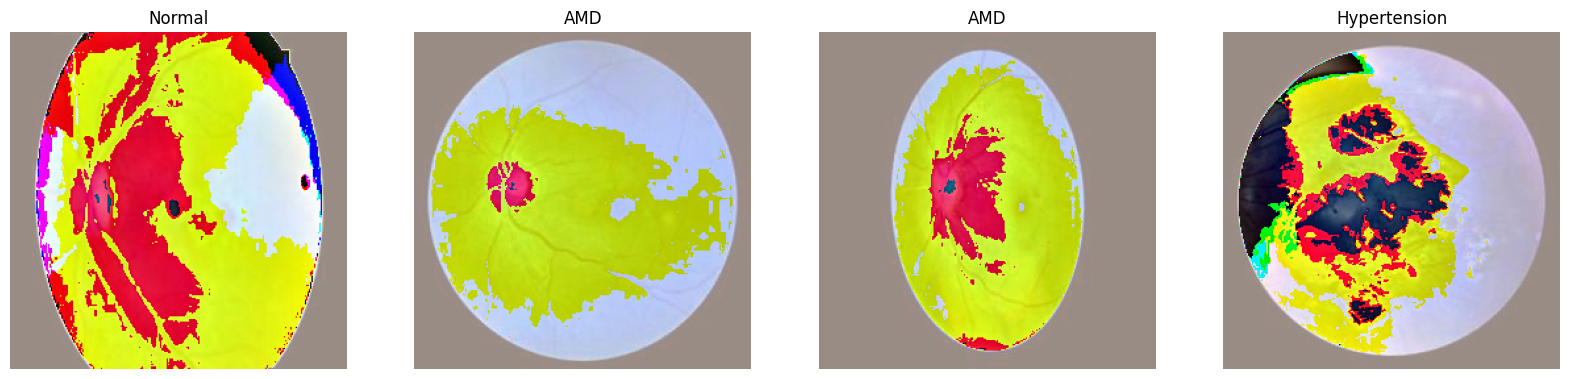

In [7]:
# Get the next batch of images from the training generator
images, labels = next(train_generator)
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Plot the images and labels using the show_batch function
def show_batch(images, labels, ncols=4):
    figure, axs = plt.subplots(1, ncols, figsize=(20, 20))
    for i in range(ncols):
        axs[i].imshow(images[i].astype('uint8'))
        axs[i].set_title(class_labels[np.argmax(labels[i])])
        axs[i].axis('off')
        
show_batch(images, labels, ncols=4)

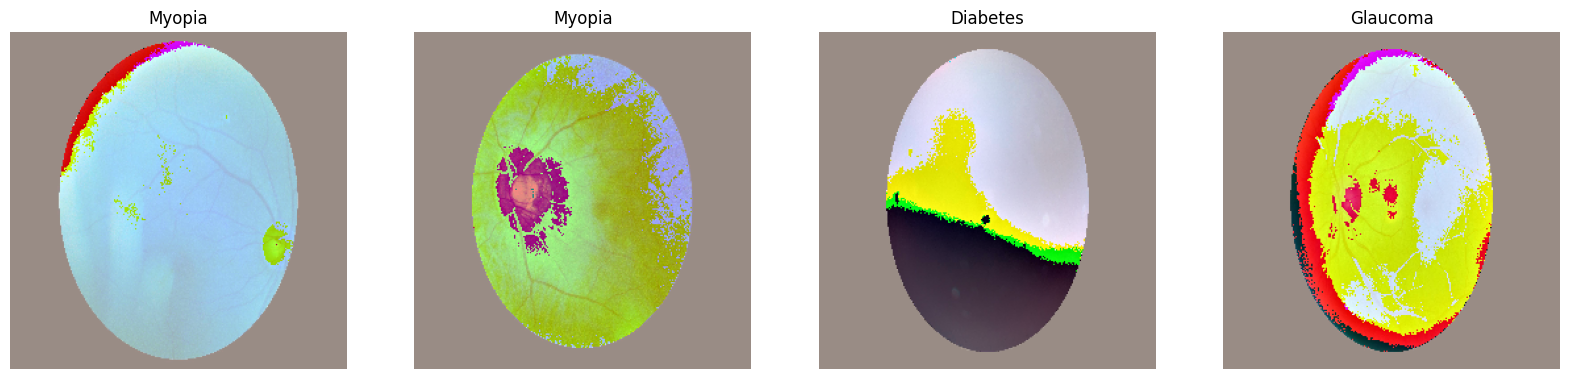

In [8]:
images, labels = next(validation_generator)
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Plot the images and labels using the show_batch function
def show_batch(images, labels, ncols=4):
    figure, axs = plt.subplots(1, ncols, figsize=(20, 20))
    for i in range(ncols):
        axs[i].imshow(images[i].astype('uint8'))
        axs[i].set_title(class_labels[np.argmax(labels[i])])
        axs[i].axis('off')
        
show_batch(images, labels, ncols=4)

# Training the model

- A BatchNormalization layer and a Dropout layer are added immediately after flattening the output of the pretrained ResNet50 base. A Dense layer with both L1 and L2 regularization follows the Dropout layer. The regularization helps prevent overfitting by adding a penalty for larger weights, and Dropout randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Batch Normalization normalizes the inputs heading into the next layer, which ensures that the network always creates activations with the same distribution that we desire.

In [9]:
validation_steps=validation_generator.samples // 32
print(validation_steps)

123


In [10]:
steps_per_epoch=train_generator.samples // 32
print(steps_per_epoch)

493


In [11]:
# Load VGG16 as a base model, excluding the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers to retain their pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top for your classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert features to vectors
x = Dense(1024, activation='relu')(x)  # A dense layer
predictions = Dense(8, activation='softmax')(x)  # New softmax layer for classification

# Define the model with the input from the base model and the output of your custom layers
vgg16_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
vgg16_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:


# Fit the model with callbacks
history = vgg16_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


Epoch 1/50
493/493 [==============================] - 152s 296ms/step - loss: 1.1349 - accuracy: 0.5884 - val_loss: 1.4613 - val_accuracy: 0.4289
Epoch 2/50
493/493 [==============================] - 146s 297ms/step - loss: 0.7478 - accuracy: 0.7370 - val_loss: 1.2736 - val_accuracy: 0.4954
Epoch 3/50
493/493 [==============================] - 147s 298ms/step - loss: 0.6090 - accuracy: 0.7953 - val_loss: 1.2013 - val_accuracy: 0.5104
Epoch 4/50
493/493 [==============================] - 146s 297ms/step - loss: 0.5175 - accuracy: 0.8360 - val_loss: 1.1438 - val_accuracy: 0.5722
Epoch 5/50
493/493 [==============================] - 147s 299ms/step - loss: 0.4455 - accuracy: 0.8620 - val_loss: 1.1600 - val_accuracy: 0.5401
Epoch 6/50
493/493 [==============================] - 147s 299ms/step - loss: 0.3857 - accuracy: 0.8862 - val_loss: 1.1142 - val_accuracy: 0.5704
Epoch 7/50
493/493 [==============================] - 148s 300ms/step - loss: 0.3429 - accuracy: 0.8959 - val_loss: 1.1027 -

# Evaluating Model 

Model Accuracy Graph Analysis

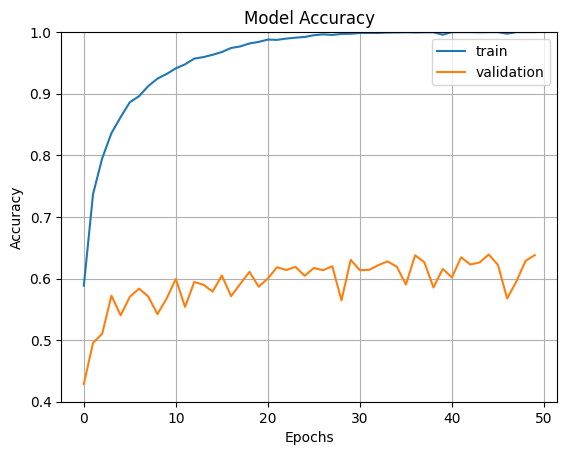

In [14]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Model Loss Graph Analysis 

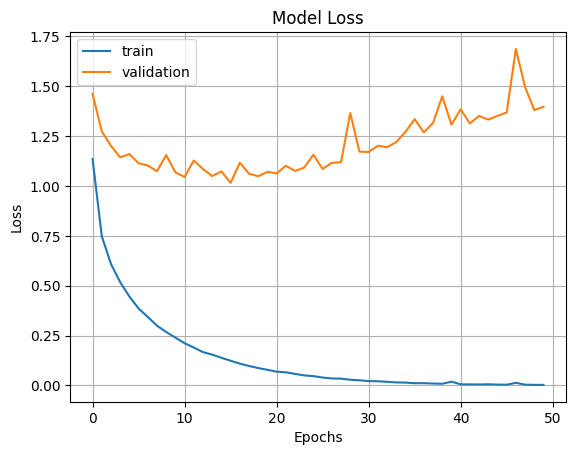

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions

In [16]:
# Assuming these were stored from the original generator before wrapping
test_samples = test_generator.samples
test_batch_size = test_generator.batch_size

# Calculate the correct number of steps to cover all the samples
steps = np.ceil(test_samples / test_batch_size)

# Evaluate the model on the test dataset
vgg16_model.evaluate(test_generator, steps=steps)

# Re-generate predictions with the corrected steps
predictions = vgg16_model.predict(test_generator, steps=steps)

# Get the predicted classes again
predicted_classes = np.argmax(predictions, axis=1)


40/40 [==============================] - 17s 415ms/step


# Predictions Result Evaluation

In [17]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report 

In [18]:

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Get the true classes from the DataFrame
true_classes = test_generator.classes

# Now, the number of predicted classes should match the number of true classes
# Generate the classification report again
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)


                precision    recall  f1-score   support

        Normal       0.30      0.22      0.25        46
      Diabetes       0.68      0.69      0.68        58
      Glaucoma       0.47      0.44      0.45       333
      Cataract       0.34      0.23      0.27        61
           AMD       0.35      0.29      0.31        28
  Hypertension       0.78      0.83      0.81        48
        Myopia       0.59      0.67      0.63       569
Other diseases       0.19      0.16      0.17       136

      accuracy                           0.52      1279
     macro avg       0.46      0.44      0.45      1279
  weighted avg       0.50      0.52      0.51      1279



Balanced Accuracy Score 

In [20]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Balanced Accuracy: 0.4410


Area Under the Reciever Operating Characteristic Curve (AUC-ROC)

In [19]:
from keras.utils import to_categorical
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.8026


Confusion Matrix 

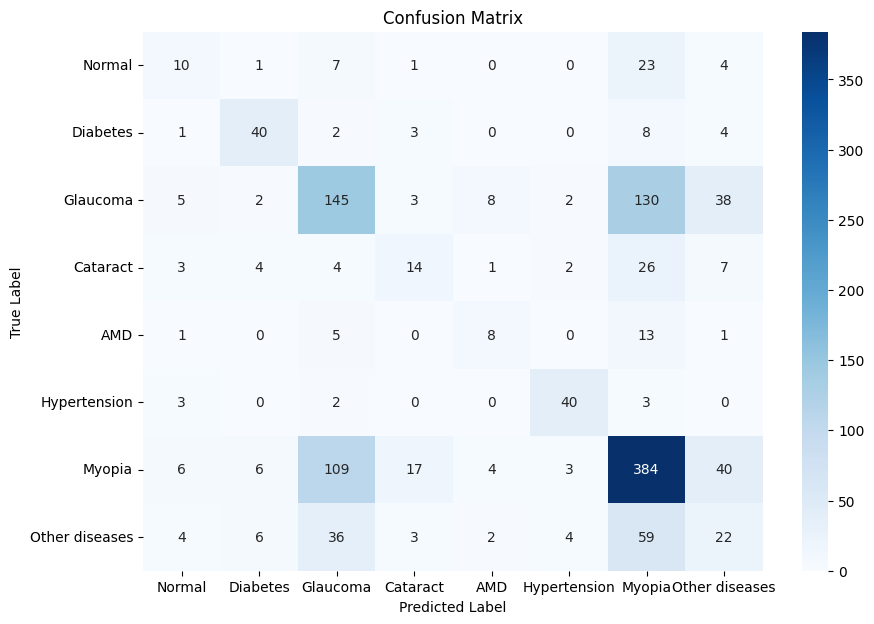

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Prediction Evaluation

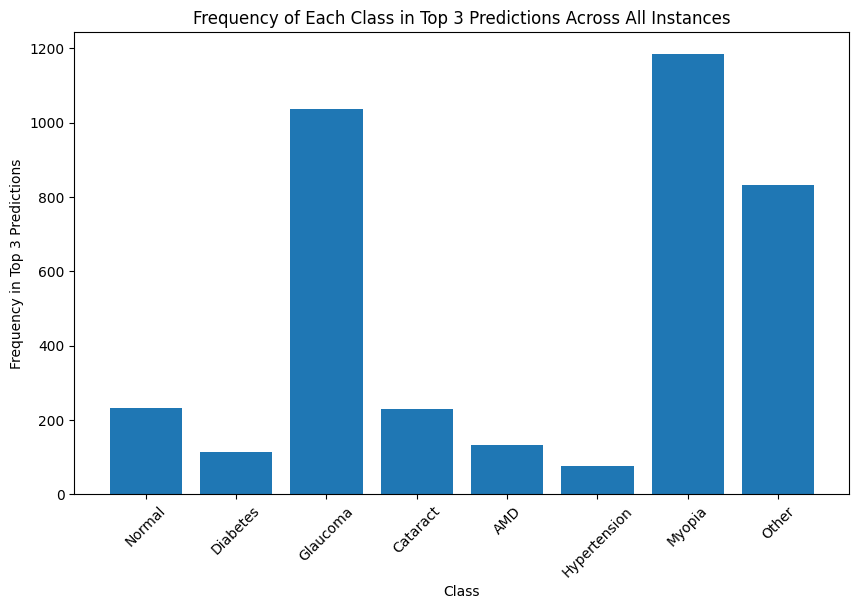

In [22]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1



# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()

In [23]:
# Save the model
resnet_50_model.save('resnet_50_model_v2.h5')

NameError: name 'resnet_50_model' is not defined